## PART 2: FUNDAMENTAL ANALYSIS

In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import pylab as py
import seaborn as sns


path = '../data/dataframe.csv'
df = pd.read_csv(path)

# INITIAL DATA MANIPUNATION
df['reference_date'] = pd.to_datetime(df['reference_date'], utc=True).dt.tz_localize(None) 
df = df.sort_values(by='reference_date') 
# Reindex the dataframe to include all timestamps
full_range = pd.date_range(df['reference_date'].min(),
                           df['reference_date'].max(),
                           freq='h')
df = df.set_index('reference_date').reindex(full_range)
# Interpolate missing values (linear ones)
df = df.interpolate(method='linear')
# Reset index if needed
df = df.reset_index().rename(columns={'index': 'reference_date'})
df.set_index('reference_date', inplace=True)
df_filtered = df.loc[:'2025-09-22 23:00:00'] # Filter on last avaiable Price observation

### **3.** Supply-Demand Balance
    - How does German demand (Demand_de) correlate with prices?
    - Analyze the relationship between renewable generation (Solar_de, Wind_de) and prices
    - What happens to prices when renewable generation is high vs. low?

#### **3.1** How does German demand (Demand_de) correlate with prices?

Pearson correlation between Price_de and Demand_de: 0.285


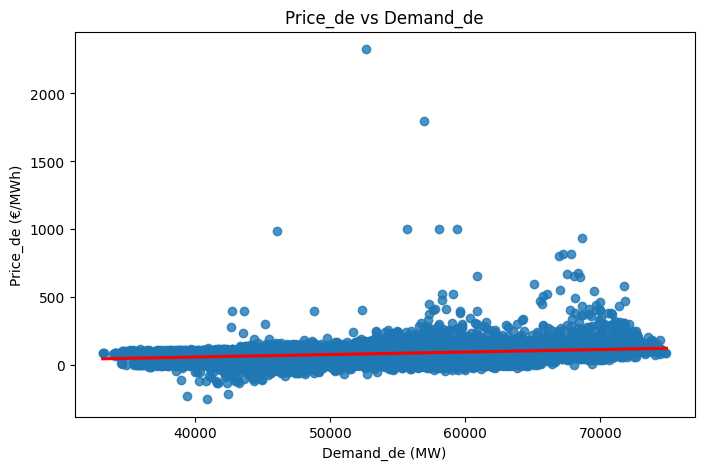

In [3]:
# Compute correlation
correlation = df_filtered["Price_de"].corr(df_filtered["Demand_de"])
print(f"Pearson correlation [Price_de and Demand_de]: {correlation:.3f}")

# Scatter plot
plt.figure(figsize=(8,5))
sns.regplot(x="Demand_de", y="Price_de", data=df_filtered, line_kws={"color": "red"})
plt.title("Price_de vs Demand_de")
plt.xlabel("Demand_de (MW)")
plt.ylabel("Price_de (€/MWh)")
plt.show()

Pearson correlation suggest weak positive relationship. correlation is not strong!

#### **3.2** Analyze the relationship between renewable generation (Solar_de, Wind_de) and prices

Correlation matrix:
           Price_de  Solar_de   Wind_de
Price_de  1.000000 -0.414797 -0.309140
Solar_de -0.414797  1.000000 -0.266702
Wind_de  -0.309140 -0.266702  1.000000


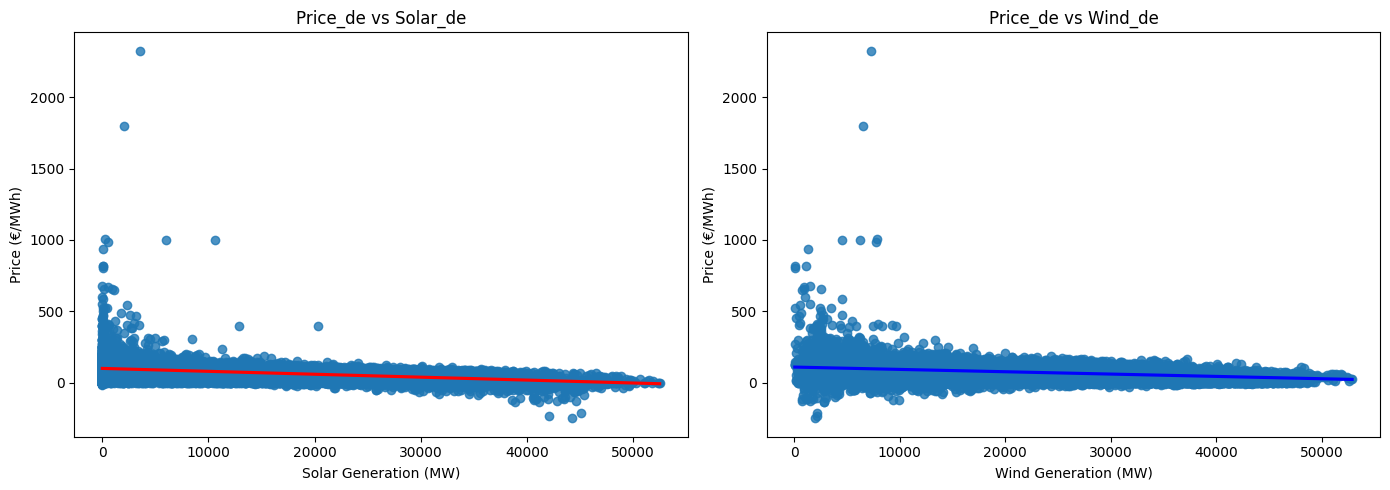

In [4]:
correlations = df_filtered[["Price_de", "Solar_de", "Wind_de"]].corr()
print("Correlation matrix:\n", correlations)
plt.figure(figsize=(14,5))

# Solar vs Price_de
plt.subplot(1, 2, 1)
sns.regplot(x="Solar_de", y="Price_de", data=df_filtered, line_kws={"color":"red"})
plt.title("Price_de vs Solar_de")
plt.xlabel("Solar Generation (MW)")
plt.ylabel("Price (€/MWh)")

# Wind vs Price_de
plt.subplot(1, 2, 2)
sns.regplot(x="Wind_de", y="Price_de", data=df_filtered, line_kws={"color":"blue"})
plt.title("Price_de vs Wind_de")
plt.xlabel("Wind Generation (MW)")
plt.ylabel("Price (€/MWh)")

plt.tight_layout()
plt.show()

*Price_de* has a moderate negative correlation with renewable generation

#### **3.3** What happens to prices when renewable generation is high vs. low?

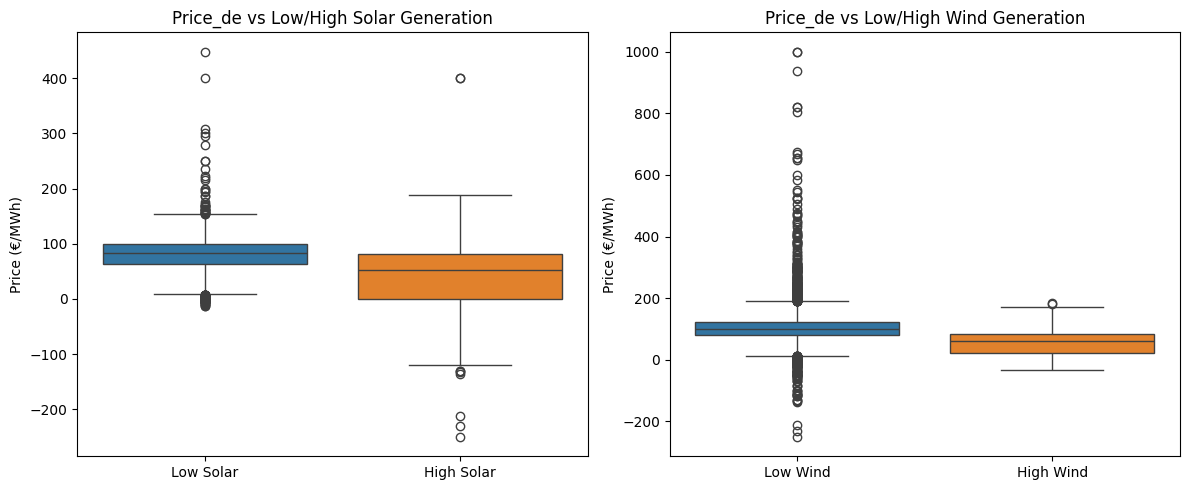

Mean prices for Solar groups:
 Low Solar     78.653145
High Solar    45.243713
dtype: float64
Mean prices for Wind groups:
 Low Wind     102.634421
High Wind     57.438549
dtype: float64


In [5]:
low_solar = df_filtered["Solar_de"].quantile(0.25)
high_solar = df_filtered["Solar_de"].quantile(0.75)

low_wind = df_filtered["Wind_de"].quantile(0.25)
high_wind = df_filtered["Wind_de"].quantile(0.75)

# Price boxplot for low vs high solar
solar_groups = pd.DataFrame({
    "Low Solar": df_filtered[df_filtered["Solar_de"] <= low_solar]["Price_de"],
    "High Solar": df_filtered[df_filtered["Solar_de"] >= high_solar]["Price_de"]
})

# Price bocplot for low vs high wind
wind_groups = pd.DataFrame({
    "Low Wind": df_filtered[df_filtered["Wind_de"] <= low_wind]["Price_de"],
    "High Wind": df_filtered[df_filtered["Wind_de"] >= high_wind]["Price_de"]
})

#plotting....
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(data=solar_groups)
plt.title("Price_de vs Low/High Solar")
plt.ylabel("Price (€/MWh)")
plt.subplot(1,2,2)
sns.boxplot(data=wind_groups)
plt.title("Price_de vs Low/High Wind Generation")
plt.ylabel("Price(€/MWh)")
plt.tight_layout()
plt.show()

# mean values can be helpful...
print("Mean prices for Solar groups:\n", solar_groups.mean())
print("Mean prices for Wind groups:\n", wind_groups.mean())

- When renewable generation (solar or wind) is high than electricity prices tend to be **significantly lower**.

- Wind generation has visibly narrower 0.25-0.75 Interquartile range but also widespread outliers with the wind production is low!


## 4. Cross-border Effects
    - Examine the impact of neighboring market demands on German prices
    - Which neighboring markets have the strongest correlation with Germany?

#### **4.1** Examine the impact of neighboring market demands on German prices

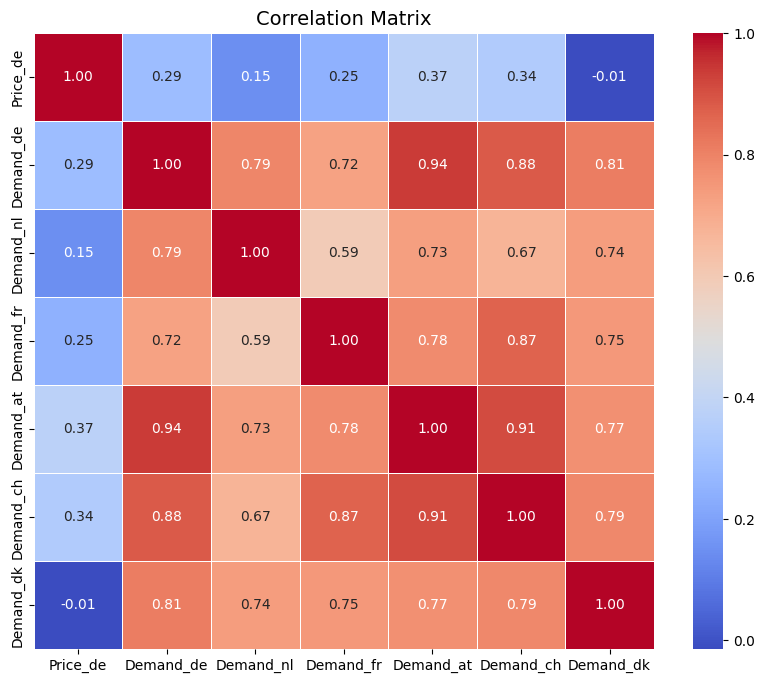

In [9]:
neighbours = ["Price_de","Demand_de","Demand_nl", "Demand_fr","Demand_at","Demand_ch", "Demand_dk"]
df_demand = df_filtered[neighbours]

correlation_matrix = df_demand.corr()

# heaemap
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix", fontsize=14)
plt.show()

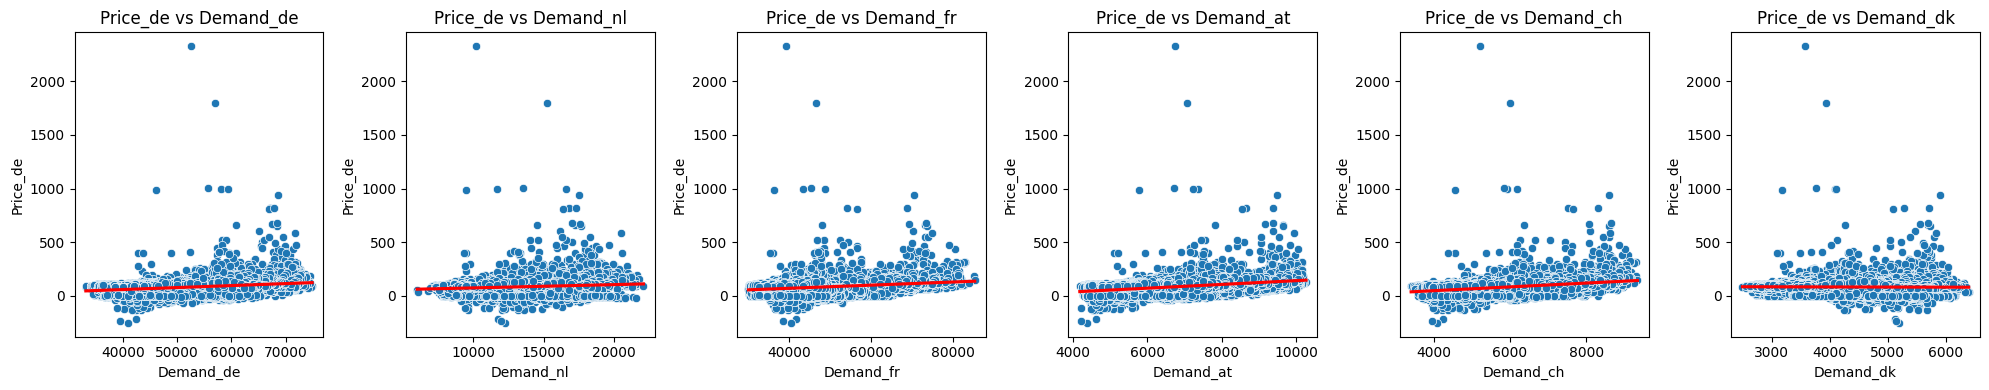

In [10]:
# scatterplots: Price_de vs each demands
plt.figure(figsize=(20,4))

for i, demand in enumerate(neighbours[1:]):  #skip Price_de
    plt.subplot(1, len(neighbours)-1, i+1)
    sns.scatterplot(x=demand, y="Price_de", data=df_demand)
    sns.regplot(x=demand, y="Price_de", data=df_demand, scatter=False, line_kws={"color":"red"})
    plt.xlabel(demand)
    plt.ylabel("Price_de")
    plt.title(f"Price_de vs {demand}")

plt.tight_layout()
plt.show()

Weak positive correlation between German prices and foreing demand, but strong within differnts demands.

#### **4.2** Which neighboring markets have the strongest correlation with Germany?

Focusing solely on demand, Austria and Switzerland show the highest correlation with German demand, whereas their impact on German prices remains relatively weak.

## 5. Fuel and Carbon Costs
    - Analyze the relationship between commodity prices (gas, coal, carbon) and electricity prices
    - Which fuel type appears to be the primary price setter in Germany?
    - How do generation costs (Cost_de) relate to market prices?